In [39]:
import csv
import json
import sys
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Set
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
print(torch.cuda.is_available())


True


### Utils

In [146]:
def load_json(file_path):
    """
    Load a JSON file and return its content as a Python dictionary.

    :param file_path: Path to the JSON file.
    :return: Dictionary containing the JSON data.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def get_participants_communications(event_id: str, nodes, edges):
    sent_edge = next((e for e in edges if e.get('type') == 'sent' and e.get('target') == event_id), None)
    # Find the 'received' edge where source is the event
    received_edge = next((e for e in edges if e.get('type') == 'received' and e.get('source') == event_id), None)

    if not sent_edge or not received_edge:
        return None, None

    source_entity_id = sent_edge['source']
    target_entity_id = received_edge['target']

    source_node = next((n for n in nodes if n.get('id') == source_entity_id), None)
    target_node = next((n for n in nodes if n.get('id') == target_entity_id), None)

    return source_node, target_node

def get_participants_relationships(event_id: str, nodes, edges):
    """
    This function give us the participant of between two entities in a relationship. Excluding the evidence
    """
    _edges = []
    for edge in edges:
        if edge.get('target') == event_id:
            _edges.append(edge)

    if len(_edges) < 2:
        return None, None
    _participant1 = _edges[0]
    _participant2 = _edges[1]
    source_entity_id = _participant1['source']
    target_entity_id = _participant2['source']

    source_node = next((n for n in nodes if n.get('id') == source_entity_id), None)
    target_node = next((n for n in nodes if n.get('id') == target_entity_id), None)

    return source_node, target_node

def create_csv(file_path: str, data: list, headers: List[str] = None):
    """
    Create a CSV file from a list of tuples.
    :param file_path: Path to the output CSV file.
    :param data: List of tuples containing the data to write to the CSV file.
    """
    with open(file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        if headers:
            writer.writerow(headers)
        for row in data:
            writer.writerow(row)


## Reading data

In [13]:
data = load_json('../data/MC3_graph.json')
schema = load_json('../data/MC3_schema.json')

In [14]:
nodes_type = schema['schema']['nodes'].keys()

## Parsing data for PAOHVIS

In [7]:
def collect_entity_names(nodes: List[Dict]) -> Set[str]:
    """Return a set with the *unique* names of all entities."""
    return {n["name"] for n in nodes if n.get("type") == "Entity"}

def extract_time_slot(raw_ts: str) -> str:
    """Convert full timestamp to a coarse *time‑slot* accepted by PAOHVis.

    Currently we keep the **date** part (`YYYY‑MM‑DD`). If `raw_ts` is null or
    malformed, we return "unknown" so the record still loads.
    """
    if not raw_ts:
        return "unknown"
    try:
        return datetime.fromisoformat(raw_ts).date().isoformat()
    except ValueError:
        return raw_ts
    
def detect_participants(content: str, entity_names: Set[str]) -> Set[str]:
    """Return the subset of `entity_names` that occur inside `content`."""
    participants = {name for name in entity_names if name in content}
    return participants

In [8]:
nodes = data.get("nodes", [])
edges = data.get("edges", [])
entity_names = collect_entity_names(nodes)

In [9]:
len(entity_names)

72

In [147]:
messages_df.shape

(584, 7)

In [153]:
messages_df

event_id             datetime  \
0          1  2040-10-01 08:09:00   
1          2  2040-10-01 08:10:00   
2          3  2040-10-01 08:13:00   
3          5  2040-10-01 08:16:00   
4          6  2040-10-01 08:19:00   
..       ...                  ...   
579      994  2040-10-14 12:50:00   
580      997  2040-10-14 12:51:00   
581      999  2040-10-14 13:31:00   
582     1001  2040-10-14 13:34:00   
583     1003  2040-10-14 13:35:00   

                                               content                source  \
0    Hey The Intern, it's The Lookout! Just spotted...           The Lookout   
1    Hey The Lookout, The Intern here! I'd absolute...            The Intern   
2    Sam, it's Kelly! Let's meet at Sunrise Point a...                 Kelly   
3    Mrs. Money, it's The Intern. Just checking in ...            The Intern   
4    Boss, it's Mrs. Money. I've reviewed our opera...            Mrs. Money   
..                                                 ...                   ...   
579  Green Guardians, Oceanus City Council here. Yo...  Oceanus City Council   
580  EcoVigil, Green Guardians HQ here. Your video ...       Green Guardians   
581  Defender to Mako. Be advised that conservation...              Defender   
582  Knowles, Mako here. Proceed to southern dock a...               Knowles   
583  Davis, this is Knowles. Approaching southern d...               Knowles   

              target                                          embedding  \
0         The Intern  [0.02924199216067791, -0.04186283424496651, 0....   
1        The Lookout  [0.03175387531518936, -0.05981292948126793, 0....   
2                Sam  [0.017817039042711258, -0.049655403941869736, ...   
3         Mrs. Money  [0.02555181086063385, -0.03967339172959328, -0...   
4               Boss  [0.03286126255989075, -0.03731901943683624, -0...   
..               ...                                                ...   
579  Green Guardians  [0.003793498734012246, -0.02744883857667446, 0...   
580         EcoVigil  [0.017483510076999664, -0.03820016235113144, 0...   
581             Mako  [0.020824257284402847, -0.013889516703784466, ...   
582            Davis  [0.03646671399474144, -0.04940148442983627, 0....   
583            Davis  [0.03445057198405266, -0.053333383053541183, 0...   

     fcluster  
0           4  
1           4  
2           4  
3           1  
4           4  
..        ...  
579         4  
580         4  
581         4  
582         4  
583         4  

[584 rows x 7 columns]

In [162]:
persons[persons['id'] == 'Sam'].is_pseudonym.values[0] == False

np.True_

In [167]:
fieldnames = ['edge_id', 'node_name', 'time_slot', 'edge_name_description', 'group_name', 'role']
messages_paohvis = []
for i in range(messages_df.shape[0]):
    row = messages_df.iloc[i]
    edge_id = row['event_id']
    source_node_name = row['source']
    target_node_name = row['target']
    time_slot = row['datetime']
    edge_name_description = row['content']
    group_name = row['fcluster']
    person_data_1 = persons[persons['id'] == row['source']]
    person_data_2 = persons[persons['id'] == row['target']]

    if person_data_1.empty:
        print(f"Warning: No person found for source {row['source']}")
        role = 'vessel'
    elif person_data_1.is_pseudonym.values[0]:
        role = 'pseudonym'
    else:
        role = 'person'
    messages_paohvis.append([edge_id, source_node_name, time_slot, edge_name_description, group_name, role])
    if person_data_2.empty:
        print(f"Warning: No person found for target {row['target']}")
        role = 'vessel'
    elif person_data_2.is_pseudonym.values[0]:
        role = 'pseudonym'
    else:
        role = 'person'
    messages_paohvis.append([edge_id, target_node_name, time_slot, edge_name_description, group_name, role])

create_csv('../data/MC3_messages.csv', messages_paohvis, fieldnames)


In [ ]:
# Create a CSV file with the required columns
output_file = '../data/MC3_data_parsed.csv'
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['edge_id', 'node_name', 'time_slot', 'edge_name_description', 'group_name', 'role']
    writer = csv.writer(csvfile)
    writer.writerow(fieldnames)
    for event in nodes:
            if event.get("type") == "Event" and event.get("sub_type") == "Communication":
                edge_id = event.get("id")
                time_slot = extract_time_slot(event.get("timestamp"))
                content = event.get("content", "")
                # A short description—trim content to first 60 chars
                edge_desc = content[:60] + ("…" if len(content) > 60 else "")

                participants = detect_participants(content, entity_names)
                if not participants:
                    # Fallback: unknown sender/receiver – still output a single row
                    writer.writerow([edge_id, "_unknown_", time_slot, edge_desc, "", ""])
                else:
                    for name in participants:
                        writer.writerow([edge_id, name, time_slot, edge_desc, "", ""])
print(f"Data parsed and saved to {output_file}")

## Question 3

1. Expanding upon your prior visual analytics, determine who is using pseudonyms to communicate, and what these pseudonyms are.
2. Describe how your visualization makes it easier to identify common entities in the data.
3. How does your understanding of activities change given your understanding of pseudonyms

In [ ]:
# Process the data to differentes kinds of events
nodes = data.get("nodes", [])
edges = data.get("edges", [])

[+] Loading graph …


I'm classifying the entities in the data as follows:
- **Pseudonyms**: These are names that users have chosen to represent themselves, which may not correspond to their real names.

In [130]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [81]:
entities = []
for entity in nodes:
    if entity.get("type") == "Entity":
        entities.append(entity)

entities_df = pd.DataFrame(entities).drop(columns=['type'])
entities_df

label           name  sub_type             id
0             Sam            Sam    Person            Sam
1           Kelly          Kelly    Person          Kelly
2     Nadia Conti    Nadia Conti    Person    Nadia Conti
3           Elise          Elise    Person          Elise
4     Liam Thorne    Liam Thorne    Person    Liam Thorne
..            ...            ...       ...            ...
67        Route C        Route C  Location        Route C
68     South Dock     South Dock  Location     South Dock
69  Castaway Cove  Castaway Cove  Location  Castaway Cove
70       Berth 14       Berth 14  Location       Berth 14
71  Port Security  Port Security  Location  Port Security

[72 rows x 4 columns]

In [102]:
persons = entities_df[entities_df['sub_type'] == 'Person']

In [124]:
persons['is_pseudonym'] = False

/tmp/ipykernel_731169/2040668371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persons['is_pseudonym'] = False


In [131]:
persons.to_csv('../data/MC3_persons.csv', index=False)

In [126]:
names = persons['name'].tolist()
for name in names:
    doc = nlp(name)
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                print(f"Found named entity: {ent.text} in name: {name}")
                persons.loc[persons['name'] == name, 'is_pseudonym'] = False
                break
            else:
                persons.loc[persons['name'] == name, 'is_pseudonym'] = True
    else:
        print(f"No named entity found in name: {name}")
        persons.loc[persons['name'] == name, 'is_pseudonym'] = True

Found named entity: Sam in name: Sam
No named entity found in name: Kelly
No named entity found in name: Elise
Found named entity: Liam Thorne in name: Liam Thorne
Found named entity: Samantha Blake in name: Samantha Blake
Found named entity: Davis in name: Davis
No named entity found in name: Rodriguez
No named entity found in name: Sailor Shift
Found named entity: Clepper Jensen in name: Clepper Jensen
Found named entity: Miranda Jordan in name: Miranda Jordan
No named entity found in name: The Intern
No named entity found in name: The Accountant
Found named entity: Money in name: Mrs. Money
No named entity found in name: The Middleman
No named entity found in name: Boss
No named entity found in name: Small Fry


In [127]:
persons

label            name sub_type              id  is_pseudonym
0              Sam             Sam   Person             Sam         False
1            Kelly           Kelly   Person           Kelly          True
2      Nadia Conti     Nadia Conti   Person     Nadia Conti          True
3            Elise           Elise   Person           Elise          True
4      Liam Thorne     Liam Thorne   Person     Liam Thorne         False
5   Samantha Blake  Samantha Blake   Person  Samantha Blake         False
6            Davis           Davis   Person           Davis         False
7        Rodriguez       Rodriguez   Person       Rodriguez          True
8     Sailor Shift    Sailor Shift   Person    Sailor Shift          True
9   Clepper Jensen  Clepper Jensen   Person  Clepper Jensen         False
10  Miranda Jordan  Miranda Jordan   Person  Miranda Jordan         False
11      The Intern      The Intern   Person      The Intern          True
12     The Lookout     The Lookout   Person     The Lookout          True
13  The Accountant  The Accountant   Person  The Accountant          True
14      Mrs. Money      Mrs. Money   Person      Mrs. Money         False
15   The Middleman   The Middleman   Person   The Middleman          True
16            Boss            Boss   Person            Boss          True
17       Small Fry       Small Fry   Person       Small Fry          True

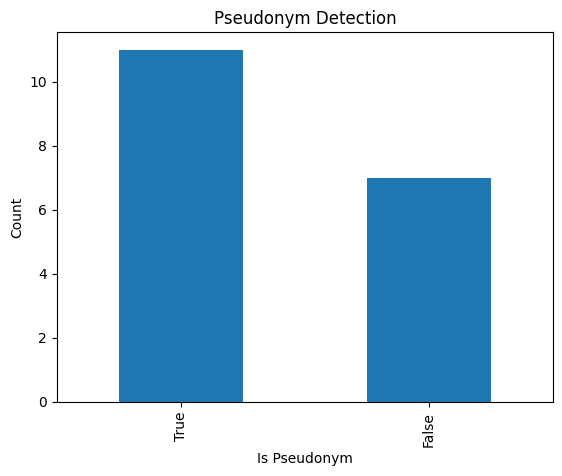

In [128]:
# Make a histogram of the number of true and false pseudonyms
persons['is_pseudonym'].value_counts().plot(kind='bar', title='Pseudonym Detection')
plt.xlabel('Is Pseudonym')
plt.ylabel('Count')
plt.show()

Processing the events, for this case i want to aggregate the communications

In [182]:
messages = []
for event in nodes:
    if event.get("type") == "Event":
        if event.get("sub_type") == "Communication":
            event_id = event.get("id")
            time_slot = event.get("timestamp")
            content = event.get("content", "")
            participants = get_participants_communications(event_id, nodes, edges)
            messages.append(
                {
                    "event_id": event_id,
                    "datetime": time_slot,
                    "content": content,
                    "source": participants[0],
                    "target": participants[1] 
            }
        )
messages_df = pd.DataFrame(messages)

In [183]:
messages_df

event_id             datetime  \
0       Event_Communication_1  2040-10-01 08:09:00   
1       Event_Communication_2  2040-10-01 08:10:00   
2       Event_Communication_3  2040-10-01 08:13:00   
3       Event_Communication_5  2040-10-01 08:16:00   
4       Event_Communication_6  2040-10-01 08:19:00   
..                        ...                  ...   
579   Event_Communication_994  2040-10-14 12:50:00   
580   Event_Communication_997  2040-10-14 12:51:00   
581   Event_Communication_999  2040-10-14 13:31:00   
582  Event_Communication_1001  2040-10-14 13:34:00   
583  Event_Communication_1003  2040-10-14 13:35:00   

                                               content  \
0    Hey The Intern, it's The Lookout! Just spotted...   
1    Hey The Lookout, The Intern here! I'd absolute...   
2    Sam, it's Kelly! Let's meet at Sunrise Point a...   
3    Mrs. Money, it's The Intern. Just checking in ...   
4    Boss, it's Mrs. Money. I've reviewed our opera...   
..                                                 ...   
579  Green Guardians, Oceanus City Council here. Yo...   
580  EcoVigil, Green Guardians HQ here. Your video ...   
581  Defender to Mako. Be advised that conservation...   
582  Knowles, Mako here. Proceed to southern dock a...   
583  Davis, this is Knowles. Approaching southern d...   

                                                source  \
0    {'type': 'Entity', 'label': 'The Lookout', 'na...   
1    {'type': 'Entity', 'label': 'The Intern', 'nam...   
2    {'type': 'Entity', 'label': 'Kelly', 'name': '...   
3    {'type': 'Entity', 'label': 'The Intern', 'nam...   
4    {'type': 'Entity', 'label': 'Mrs. Money', 'nam...   
..                                                 ...   
579  {'type': 'Entity', 'label': 'Oceanus City Coun...   
580  {'type': 'Entity', 'label': 'Green Guardians',...   
581  {'type': 'Entity', 'label': 'Defender', 'name'...   
582  {'type': 'Entity', 'label': 'Knowles', 'name':...   
583  {'type': 'Entity', 'label': 'Knowles', 'name':...   

                                                target  
0    {'type': 'Entity', 'label': 'The Intern', 'nam...  
1    {'type': 'Entity', 'label': 'The Lookout', 'na...  
2    {'type': 'Entity', 'label': 'Sam', 'name': 'Sa...  
3    {'type': 'Entity', 'label': 'Mrs. Money', 'nam...  
4    {'type': 'Entity', 'label': 'Boss', 'name': 'B...  
..                                                 ...  
579  {'type': 'Entity', 'label': 'Green Guardians',...  
580  {'type': 'Entity', 'label': 'EcoVigil', 'name'...  
581  {'type': 'Entity', 'label': 'Mako', 'name': 'M...  
582  {'type': 'Entity', 'label': 'Davis', 'name': '...  
583  {'type': 'Entity', 'label': 'Davis', 'name': '...  

[584 rows x 5 columns]

In [ ]:
# Parsing the event_id to remove the prefix 'Event_Communication_'
messages_df['event_id'] = messages_df['event_id'].str.replace('Event_Communication_', '', regex=False)
messages_df['target'] = messages_df['target'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
messages_df['source'] = messages_df['source'].apply(lambda x: x['id'] if isinstance(x, dict) else x)

In [189]:
import ast
import networkx as nx

if messages_df['source'].dtype == object and isinstance(messages_df.loc[0, 'source'], str):
    messages_df['src_dict'] = messages_df['source'].apply(ast.literal_eval)
    messages_df['tgt_dict'] = messages_df['target'].apply(ast.literal_eval)
else:
    # or if they’re already dicts:
    messages_df['src_dict'] = messages_df['source']
    messages_df['tgt_dict'] = messages_df['target']

# 3) pick a unique node key, e.g. the “name” field (falling back to label)
def pick_key(d):
    return d.get('name') or d.get('label')

messages_df['src_node'] = messages_df['src_dict'].apply(pick_key)
messages_df['tgt_node'] = messages_df['tgt_dict'].apply(pick_key)

# 4a) Quickly build a DiGraph via from_pandas_edgelist (edge attrs = event_id, datetime, content):
G = nx.from_pandas_edgelist(
    messages_df,
    source='src_node',
    target='tgt_node',
    edge_attr=['event_id','datetime','content'],
    create_using=nx.DiGraph()
)

# 4b) If you also want to attach the node‐level metadata (type/label/name), do:
for _, row in messages_df.iterrows():
    G.nodes[row['src_node']].update(row['src_dict'])
    G.nodes[row['tgt_node']].update(row['tgt_dict'])


In [191]:
from networkx.readwrite import json_graph
data_final = json_graph.node_link_data(G)

# 2) Write out to disk (or return from an API)
with open("../data/graph_communication.json", "w") as f:
    json.dump(data_final, f, indent=2)

Processingt the relationships, for this case i want to aggregate the relationships between the entities

In [100]:
relationships = []
for event in nodes:    
    if event.get("type") == "Relationship":
        event_id = event.get("id")
        participants = get_participants_relationships(event_id, nodes, edges)
        relationships.append(
            {
                "event_id": event_id,
                "sub_type": event.get("sub_type"),
                "label": event.get("label"),
                "friendship_type": event.get("friendship_type"),
                "participant1": participants[0],
                "participant2": participants[1]
            }
        )
relationships_df = pd.DataFrame(relationships)
relationships_df['event_id'] = relationships_df['event_id'].str.replace('Relationship_', '', regex=False)
relationships_df['participant1'] = relationships_df['participant1'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
relationships_df['participant2'] = relationships_df['participant2'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
relationships_df

event_id    sub_type       label friendship_type  \
0         Friends_0     Friends     Friends        informal   
1       Friends_272     Friends     Friends   collaborative   
2      Colleagues_2  Colleagues  Colleagues            None   
3     Colleagues_11  Colleagues  Colleagues            None   
4     Colleagues_16  Colleagues  Colleagues            None   
..              ...         ...         ...             ...   
280  Unfriendly_130  Unfriendly  Unfriendly            None   
281  Unfriendly_229  Unfriendly  Unfriendly            None   
282  Unfriendly_312  Unfriendly  Unfriendly            None   
283  Unfriendly_567  Unfriendly  Unfriendly            None   
284  Unfriendly_625  Unfriendly  Unfriendly            None   

             participant1             participant2  
0              The Intern              The Lookout  
1                     Sam                    Kelly  
2              Mrs. Money                     Boss  
3           The Middleman                     Boss  
4               Rodriguez       Sailor Shifts Team  
..                    ...                      ...  
280        Northern Light  Event_Communication_234  
281        Samantha Blake  Event_Communication_382  
282    V. Miesel Shipping  Event_Communication_528  
283       Green Guardians  Event_Communication_902  
284  Oceanus City Council  Event_Communication_882  

[285 rows x 6 columns]

In [103]:
relationships_person_person = relationships_df[
    (relationships_df['participant1'].isin(persons['id'])) & 
    (relationships_df['participant2'].isin(persons['id']))
]


In [104]:
relationships_person_person

event_id          sub_type             label friendship_type  \
0               Friends_0           Friends           Friends        informal   
1             Friends_272           Friends           Friends   collaborative   
2            Colleagues_2        Colleagues        Colleagues            None   
3           Colleagues_11        Colleagues        Colleagues            None   
5           Colleagues_45        Colleagues        Colleagues            None   
9           Colleagues_84        Colleagues        Colleagues            None   
10         Colleagues_102        Colleagues        Colleagues            None   
12         Colleagues_158        Colleagues        Colleagues            None   
13         Colleagues_215        Colleagues        Colleagues            None   
14         Colleagues_290        Colleagues        Colleagues            None   
17         Colleagues_321        Colleagues        Colleagues            None   
18         Colleagues_322        Colleagues        Colleagues            None   
20         Colleagues_430        Colleagues        Colleagues            None   
21         Colleagues_431        Colleagues        Colleagues            None   
22         Colleagues_494        Colleagues        Colleagues            None   
23         Colleagues_535        Colleagues        Colleagues            None   
24         Colleagues_536        Colleagues        Colleagues            None   
25         Colleagues_551        Colleagues        Colleagues            None   
26         Colleagues_589        Colleagues        Colleagues            None   
27         Colleagues_599        Colleagues        Colleagues            None   
28         Colleagues_601        Colleagues        Colleagues            None   
29         Colleagues_617        Colleagues        Colleagues            None   
30         Colleagues_619        Colleagues        Colleagues            None   
79   AccessPermission_425  AccessPermission  AccessPermission            None   
232          Operates_352          Operates          Operates            None   
234          Operates_439          Operates          Operates            None   
272        Suspicious_426        Suspicious        Suspicious            None   
277        Suspicious_485        Suspicious        Suspicious            None   

       participant1    participant2  
0        The Intern     The Lookout  
1               Sam           Kelly  
2        Mrs. Money            Boss  
3     The Middleman            Boss  
5             Davis    Sailor Shift  
9        The Intern      Mrs. Money  
10        Rodriguez            Boss  
12       Mrs. Money   The Middleman  
13              Sam           Kelly  
14   Clepper Jensen  Miranda Jordan  
17      Nadia Conti           Elise  
18      Nadia Conti  The Accountant  
20              Sam           Elise  
21              Sam     Nadia Conti  
22      Nadia Conti     Liam Thorne  
23             Boss       Small Fry  
24            Davis            Boss  
25      Nadia Conti           Davis  
26       The Intern     The Lookout  
27   The Accountant            Boss  
28   The Accountant   The Middleman  
29            Davis       Small Fry  
30            Davis       Rodriguez  
79       The Intern      Mrs. Money  
232           Davis       Rodriguez  
234      The Intern      Mrs. Money  
272      The Intern      Mrs. Money  
277  Clepper Jensen  Miranda Jordan

## Generating Embeddings using Local model

In [6]:
MODEL_NAME  = "intfloat/e5-large-v2"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 128

In [7]:
DEVICE

'cuda'

In [8]:
encoder = SentenceTransformer(MODEL_NAME, device=DEVICE)

In [23]:
from typing import List, Dict
def embed_messages(messages: List[Dict],
                   key: str = "embedding") -> List[Dict]:
    """
    Adds a GPU-generated 1024-d embedding under messages[i][key].
    Runs fully offline.
    """
    texts = [m["content"] for m in messages]

    # E5 models expect 'query: ' or 'passage: ' prefixes – use passage mode
    texts = [f"passage: {t}" for t in texts]

    vectors = encoder.encode(
        texts,
        batch_size=BATCH_SIZE,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    for msg, vec in zip(messages, vectors):
        msg[key] = vec.tolist()        # keep JSON-serialisable

    return messages

In [24]:
messages_with_embeddings = embed_messages(messages)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


In [ ]:
output_file = '../data/MC3_data_comunications_with_embeddings.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(messages_with_embeddings, f, indent=2, ensure_ascii=False)
print(f"Data with embeddings saved to {output_file}")

Data with embeddings saved to ../data/MC3_data_comunications_with_embeddings.json


## Analysis of the communication embeddings

In [54]:
messages_df = pd.DataFrame(messages)
messages_df.head(10)

event_id             datetime  \
0   Event_Communication_1  2040-10-01 08:09:00   
1   Event_Communication_2  2040-10-01 08:10:00   
2   Event_Communication_3  2040-10-01 08:13:00   
3   Event_Communication_5  2040-10-01 08:16:00   
4   Event_Communication_6  2040-10-01 08:19:00   
5   Event_Communication_7  2040-10-01 08:21:00   
6   Event_Communication_8  2040-10-01 08:24:00   
7   Event_Communication_9  2040-10-01 08:26:00   
8  Event_Communication_10  2040-10-01 08:29:00   
9  Event_Communication_11  2040-10-01 08:32:00   

                                             content  \
0  Hey The Intern, it's The Lookout! Just spotted...   
1  Hey The Lookout, The Intern here! I'd absolute...   
2  Sam, it's Kelly! Let's meet at Sunrise Point a...   
3  Mrs. Money, it's The Intern. Just checking in ...   
4  Boss, it's Mrs. Money. I've reviewed our opera...   
5  Mrs. Money, this is Boss. I'm available tomorr...   
6  Boss, Mrs. Money here. I'll bring the updated ...   
7  Middleman, this is Boss. I'd like to move our ...   
8  Boss, this is The Middleman. I can meet earlie...   
9  Middleman, this is Boss. Let's meet tomorrow a...   

                                              source  \
0  {'type': 'Entity', 'label': 'The Lookout', 'na...   
1  {'type': 'Entity', 'label': 'The Intern', 'nam...   
2  {'type': 'Entity', 'label': 'Kelly', 'name': '...   
3  {'type': 'Entity', 'label': 'The Intern', 'nam...   
4  {'type': 'Entity', 'label': 'Mrs. Money', 'nam...   
5  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   
6  {'type': 'Entity', 'label': 'Mrs. Money', 'nam...   
7  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   
8  {'type': 'Entity', 'label': 'The Middleman', '...   
9  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   

                                              target  \
0  {'type': 'Entity', 'label': 'The Intern', 'nam...   
1  {'type': 'Entity', 'label': 'The Lookout', 'na...   
2  {'type': 'Entity', 'label': 'Sam', 'name': 'Sa...   
3  {'type': 'Entity', 'label': 'Mrs. Money', 'nam...   
4  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   
5  {'type': 'Entity', 'label': 'Mrs. Money', 'nam...   
6  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   
7  {'type': 'Entity', 'label': 'The Middleman', '...   
8  {'type': 'Entity', 'label': 'Boss', 'name': 'B...   
9  {'type': 'Entity', 'label': 'The Middleman', '...   

                                           embedding  
0  [0.02924199216067791, -0.04186283424496651, 0....  
1  [0.03175387531518936, -0.05981292948126793, 0....  
2  [0.017817039042711258, -0.049655403941869736, ...  
3  [0.02555181086063385, -0.03967339172959328, -0...  
4  [0.03286126255989075, -0.03731901943683624, -0...  
5  [0.01907256618142128, -0.05098648741841316, 0....  
6  [0.016821151599287987, -0.06205510348081589, 0...  
7  [0.04015498608350754, -0.046918272972106934, 0...  
8  [0.03250553831458092, -0.03965483233332634, 0....  
9  [0.01835772581398487, -0.056135788559913635, 0...

In [47]:
unique_event_ids = messages_df['event_id'].unique()
print(f"Number of unique event IDs: {len(unique_event_ids)}")

Number of unique event IDs: 584


In [49]:
# I want to verify if i have duplicates in the event IDs
duplicates = messages_df[messages_df.duplicated(subset=['event_id'], keep=False)]
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate event IDs:")
    print(duplicates[['event_id', 'content']])
else:
    print("No duplicate event IDs found.")

No duplicate event IDs found.


In [168]:
messages_df

event_id             datetime  \
0          1  2040-10-01 08:09:00   
1          2  2040-10-01 08:10:00   
2          3  2040-10-01 08:13:00   
3          5  2040-10-01 08:16:00   
4          6  2040-10-01 08:19:00   
..       ...                  ...   
579      994  2040-10-14 12:50:00   
580      997  2040-10-14 12:51:00   
581      999  2040-10-14 13:31:00   
582     1001  2040-10-14 13:34:00   
583     1003  2040-10-14 13:35:00   

                                               content                source  \
0    Hey The Intern, it's The Lookout! Just spotted...           The Lookout   
1    Hey The Lookout, The Intern here! I'd absolute...            The Intern   
2    Sam, it's Kelly! Let's meet at Sunrise Point a...                 Kelly   
3    Mrs. Money, it's The Intern. Just checking in ...            The Intern   
4    Boss, it's Mrs. Money. I've reviewed our opera...            Mrs. Money   
..                                                 ...                   ...   
579  Green Guardians, Oceanus City Council here. Yo...  Oceanus City Council   
580  EcoVigil, Green Guardians HQ here. Your video ...       Green Guardians   
581  Defender to Mako. Be advised that conservation...              Defender   
582  Knowles, Mako here. Proceed to southern dock a...               Knowles   
583  Davis, this is Knowles. Approaching southern d...               Knowles   

              target                                          embedding  \
0         The Intern  [0.02924199216067791, -0.04186283424496651, 0....   
1        The Lookout  [0.03175387531518936, -0.05981292948126793, 0....   
2                Sam  [0.017817039042711258, -0.049655403941869736, ...   
3         Mrs. Money  [0.02555181086063385, -0.03967339172959328, -0...   
4               Boss  [0.03286126255989075, -0.03731901943683624, -0...   
..               ...                                                ...   
579  Green Guardians  [0.003793498734012246, -0.02744883857667446, 0...   
580         EcoVigil  [0.017483510076999664, -0.03820016235113144, 0...   
581             Mako  [0.020824257284402847, -0.013889516703784466, ...   
582            Davis  [0.03646671399474144, -0.04940148442983627, 0....   
583            Davis  [0.03445057198405266, -0.053333383053541183, 0...   

     fcluster  
0           4  
1           4  
2           4  
3           1  
4           4  
..        ...  
579         4  
580         4  
581         4  
582         4  
583         4  

[584 rows x 7 columns]

In [170]:
messages_to_test = messages_df.drop(columns=['embedding', 'fcluster']).copy()

In [172]:
messages_to_test.to_csv('../src/question_3_propostal/MC3_messages_to_test.csv', index=False)

In [ ]:
# create a matrix person against person with the number of messages between them
person_person_matrix = pd.DataFrame(0, index=persons['id'], columns=persons['id'])
person_person_matrix

id              Sam  Kelly  Nadia Conti  Elise  Liam Thorne  Samantha Blake  \
id                                                                            
Sam               0      0            0      0            0               0   
Kelly             0      0            0      0            0               0   
Nadia Conti       0      0            0      0            0               0   
Elise             0      0            0      0            0               0   
Liam Thorne       0      0            0      0            0               0   
Samantha Blake    0      0            0      0            0               0   
Davis             0      0            0      0            0               0   
Rodriguez         0      0            0      0            0               0   
Sailor Shift      0      0            0      0            0               0   
Clepper Jensen    0      0            0      0            0               0   
Miranda Jordan    0      0            0      0            0               0   
The Intern        0      0            0      0            0               0   
The Lookout       0      0            0      0            0               0   
The Accountant    0      0            0      0            0               0   
Mrs. Money        0      0            0      0            0               0   
The Middleman     0      0            0      0            0               0   
Boss              0      0            0      0            0               0   
Small Fry         0      0            0      0            0               0   

id              Davis  Rodriguez  Sailor Shift  Clepper Jensen  \
id                                                               
Sam                 0          0             0               0   
Kelly               0          0             0               0   
Nadia Conti         0          0             0               0   
Elise               0          0             0               0   
Liam Thorne         0          0             0               0   
Samantha Blake      0          0             0               0   
Davis               0          0             0               0   
Rodriguez           0          0             0               0   
Sailor Shift        0          0             0               0   
Clepper Jensen      0          0             0               0   
Miranda Jordan      0          0             0               0   
The Intern          0          0             0               0   
The Lookout         0          0             0               0   
The Accountant      0          0             0               0   
Mrs. Money          0          0             0               0   
The Middleman       0          0             0               0   
Boss                0          0             0               0   
Small Fry           0          0             0               0   

id              Miranda Jordan  The Intern  The Lookout  The Accountant  \
id                                                                        
Sam                          0           0            0               0   
Kelly                        0           0            0               0   
Nadia Conti                  0           0            0               0   
Elise                        0           0            0               0   
Liam Thorne                  0           0            0               0   
Samantha Blake               0           0            0               0   
Davis                        0           0            0               0   
Rodriguez                    0           0            0               0   
Sailor Shift                 0           0            0               0   
Clepper Jensen               0           0            0               0   
Miranda Jordan               0           0            0               0   
The Intern                   0           0            0               0   
The Lookout                  0           0      

In [175]:
for i in range(messages_df.shape[0]):
    try:
        if messages_df.iloc[i]['source'] not in person_person_matrix.index or messages_df.iloc[i]['target'] not in person_person_matrix.columns:
            continue
    except KeyError:
        print(f"KeyError at index {i} for source {messages_df.iloc[i]['source']} or target {messages_df.iloc[i]['target']}")
        continue
    row = messages_df.iloc[i]
    source = row['source']
    target = row['target']
    person_person_matrix.loc[source, target] += 1

person_person_matrix = person_person_matrix + person_person_matrix.T
person_person_matrix = person_person_matrix.fillna(0)
person_person_matrix



id              Sam  Kelly  Nadia Conti  Elise  Liam Thorne  Samantha Blake  \
id                                                                            
Sam               0      3            0      0            0               0   
Kelly             3      0            0      0            0               0   
Nadia Conti       0      0            0      3            4               0   
Elise             0      0            3      0            2               0   
Liam Thorne       0      0            4      2            0               0   
Samantha Blake    0      0            0      0            0               0   
Davis             0      0            5      0            0               0   
Rodriguez         0      0            1      0            0               0   
Sailor Shift      0      0            0      0            0               0   
Clepper Jensen    0      0            0      0            0               0   
Miranda Jordan    0      0            0      0            0               0   
The Intern        0      0            0      0            0               0   
The Lookout       8      0            0      0            0               0   
The Accountant    0      0            0      0            0               0   
Mrs. Money        0      0            0      0            0               0   
The Middleman     0      0            0      0            2               0   
Boss              0      0            0      0            1               0   
Small Fry         0      0            0      0            0               0   

id              Davis  Rodriguez  Sailor Shift  Clepper Jensen  \
id                                                               
Sam                 0          0             0               0   
Kelly               0          0             0               0   
Nadia Conti         5          1             0               0   
Elise               0          0             0               0   
Liam Thorne         0          0             0               0   
Samantha Blake      0          0             0               0   
Davis              12          3             0               0   
Rodriguez           3          8             0               0   
Sailor Shift        0          0             0               0   
Clepper Jensen      0          0             0               0   
Miranda Jordan      0          0             0              38   
The Intern          0          0             0               0   
The Lookout         0          0             0               0   
The Accountant      0          0             0               0   
Mrs. Money          0          1             0               0   
The Middleman       0          0             0               0   
Boss                1          3             0               0   
Small Fry           2          0             0               0   

id              Miranda Jordan  The Intern  The Lookout  The Accountant  \
id                                                                        
Sam                          0           0            8               0   
Kelly                        0           0            0               0   
Nadia Conti                  0           0            0               0   
Elise                        0           0            0               0   
Liam Thorne                  0           0            0               0   
Samantha Blake               0           0            0               0   
Davis                        0           0            0               0   
Rodriguez                    0           0            0               0   
Sailor Shift                 0           0            0               0   
Clepper Jensen              38           0            0               0   
Miranda Jordan               0           0            0               0   
The Intern                   0           2           20               0   
The Lookout                  0          20      

In [180]:
# calculate the density of the matrix
density = person_person_matrix.sum().sum() / (len(person_person_matrix))
print(f"Density of the person-person matrix: {density:.4f}")

Density of the person-person matrix: 17.4444


In [181]:
# Calculate the similarity between rows
similarity_matrix = person_person_matrix.dot(person_person_matrix.T)
similarity_matrix = similarity_matrix / np.linalg.norm(similarity_matrix, axis=1, keepdims=True)
similarity_matrix = pd.DataFrame(similarity_matrix, index=person_person_matrix.index, columns=person_person_matrix.index)
similarity_matrix

id                   Sam     Kelly  Nadia Conti     Elise  Liam Thorne  \
id                                                                       
Sam             0.415088  0.000000     0.000000  0.000000     0.000000   
Kelly           0.000000  0.351123     0.000000  0.000000     0.000000   
Nadia Conti     0.000000  0.000000     0.588583  0.092327     0.069245   
Elise           0.000000  0.000000     0.318475  0.517522     0.477712   
Liam Thorne     0.000000  0.000000     0.130189  0.260378     0.542454   
Samantha Blake       NaN       NaN          NaN       NaN          NaN   
Davis           0.000000  0.000000     0.300385  0.071520     0.100128   
Rodriguez       0.000000  0.000000     0.180255  0.023512     0.054860   
Sailor Shift         NaN       NaN          NaN       NaN          NaN   
Clepper Jensen  0.000000  0.000000     0.000000  0.000000     0.000000   
Miranda Jordan  0.000000  0.000000     0.000000  0.000000     0.000000   
The Intern      0.187264  0.000000     0.000000  0.000000     0.000000   
The Lookout     0.000000  0.039063     0.000000  0.000000     0.000000   
The Accountant  0.000000  0.000000     0.000000  0.000000     0.170103   
Mrs. Money      0.000000  0.000000     0.001473  0.000000     0.032405   
The Middleman   0.000000  0.000000     0.041973  0.020986     0.036726   
Boss            0.000000  0.000000     0.043312  0.007219     0.050530   
Small Fry       0.000000  0.000000     0.369611  0.000000     0.000000   

id              Samantha Blake     Davis  Rodriguez  Sailor Shift  \
id                                                                  
Sam                        0.0  0.000000   0.000000           0.0   
Kelly                      0.0  0.000000   0.000000           0.0   
Nadia Conti                0.0  0.727074   0.265440           0.0   
Elise                      0.0  0.597141   0.119428           0.0   
Liam Thorne                0.0  0.455661   0.151887           0.0   
Samantha Blake             NaN       NaN        NaN           NaN   
Davis                      0.0  0.872547   0.324225           0.0   
Rodriguez                  0.0  0.532928   0.658323           0.0   
Sailor Shift               NaN       NaN        NaN           NaN   
Clepper Jensen             0.0  0.000000   0.000000           0.0   
Miranda Jordan             0.0  0.000000   0.000000           0.0   
The Intern                 0.0  0.000000   0.023408           0.0   
The Lookout                0.0  0.000000   0.000000           0.0   
The Accountant             0.0  0.034021   0.102062           0.0   
Mrs. Money                 0.0  0.019148   0.055972           0.0   
The Middleman              0.0  0.036726   0.141659           0.0   
Boss                       0.0  0.075795   0.133544           0.0   
Small Fry                  0.0  0.887066   0.221766           0.0   

id              Clepper Jensen  Miranda Jordan  The Intern  The Lookout  \
id                                                                        
Sam                        0.0             0.0    0.909781     0.000000   
Kelly                      0.0             0.0    0.000000     0.936329   
Nadia Conti                0.0             0.0    0.000000     0.000000   
Elise                      0.0             0.0    0.000000     0.000000   
Liam Thorne                0.0             0.0    0.000000     0.000000   
Samantha Blake             NaN             NaN         NaN          NaN   
Davis                      0.0             0.0    0.000000     0.000000   
Rodriguez                  0.0             0.0    0.156743     0.000000   
Sailor Shift               NaN             NaN         NaN          NaN   
Clepper Jensen             1.0             0.0    0.000000     0.000000   
Miranda Jordan             0.0             1.0    0.000000     0.000000   
The Intern                 0.0             0.0    0.941001     0.046816   
The Lookout                0.0             0.0    0.065105     0.755224   
The Accountan

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(messages_df: pd.DataFrame, key: str = "embedding") -> np.ndarray:
    """
    Compute the cosine similarity matrix for the embeddings in a pandas DataFrame.
    Each row should contain an embedding under the column `key`.
    """
    embeddings = np.array(messages_df[key].tolist())
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix


In [62]:
similarity_matrix = compute_similarity_matrix(messages_df)
print(f"Similarity matrix shape: {similarity_matrix.shape}")

# Put the similarity matrix into a DataFrame for easier handling, using event IDs from messages_df
similarity_df = pd.DataFrame(similarity_matrix, index=messages_df['event_id'], columns=messages_df['event_id'])
similarity_df.head(10)

Similarity matrix shape: (584, 584)


event_id         1         2         3         5         6         7  \
event_id                                                               
1         1.000000  0.940137  0.868656  0.867727  0.804350  0.818316   
2         0.940137  1.000000  0.862849  0.897628  0.827522  0.833921   
3         0.868656  0.862849  1.000000  0.815577  0.795765  0.830172   
5         0.867727  0.897628  0.815577  1.000000  0.903651  0.870881   
6         0.804350  0.827522  0.795765  0.903651  1.000000  0.930679   
7         0.818316  0.833921  0.830172  0.870881  0.930679  1.000000   
8         0.843212  0.851233  0.809259  0.860041  0.887617  0.917990   
9         0.827455  0.836766  0.824956  0.852345  0.914068  0.898364   
10        0.836619  0.837326  0.822343  0.831770  0.878387  0.880581   
11        0.835150  0.836994  0.846565  0.819891  0.862843  0.911323   

event_id         8         9        10        11  ...       986       987  \
event_id                                          ...                       
1         0.843212  0.827455  0.836619  0.835150  ...  0.784462  0.820187   
2         0.851233  0.836766  0.837326  0.836994  ...  0.772265  0.809920   
3         0.809259  0.824956  0.822343  0.846565  ...  0.805662  0.828036   
5         0.860041  0.852345  0.831770  0.819891  ...  0.782462  0.816039   
6         0.887617  0.914068  0.878387  0.862843  ...  0.778852  0.806463   
7         0.917990  0.898364  0.880581  0.911323  ...  0.803264  0.808478   
8         1.000000  0.901108  0.912158  0.915890  ...  0.799577  0.817793   
9         0.901108  1.000000  0.954264  0.935314  ...  0.796009  0.829587   
10        0.912158  0.954264  1.000000  0.947557  ...  0.805839  0.814102   
11        0.915890  0.935314  0.947557  1.000000  ...  0.818863  0.816181   

event_id       989       991       993       994       997       999  \
event_id                                                               
1         0.809936  0.829888  0.781508  0.780428  0.806603  0.765071   
2         0.798169  0.823279  0.755330  0.767535  0.796377  0.747842   
3         0.802207  0.786801  0.754838  0.781344  0.761040  0.742296   
5         0.795551  0.788294  0.752128  0.773719  0.770132  0.732070   
6         0.800771  0.775197  0.759764  0.786437  0.742071  0.723409   
7         0.827795  0.783434  0.764220  0.800065  0.766805  0.744671   
8         0.850402  0.828317  0.794250  0.794458  0.827251  0.768694   
9         0.839925  0.824465  0.793139  0.800801  0.801495  0.783719   
10        0.859287  0.847136  0.818804  0.820814  0.842932  0.802333   
11        0.858745  0.833011  0.818937  0.806907  0.828879  0.790956   

event_id      1001      1003  
event_id                      
1         0.794302  0.797075  
2         0.782557  0.781808  
3         0.812566  0.812818  
5         0.789700  0.799118  
6         0.804223  0.808729  
7         0.816045  0.817586  
8         0.811570  0.808163  
9         0.825411  0.819222  
10        0.819451  0.810775  
11        0.831219  0.824598  

[10 rows x 584 columns]

In [63]:
# Using UMAP i want to reduce the dimensionality of the embeddings and plot them in 3D space 
def reduce_dimensions(embeddings: np.ndarray, n_components: int = 3) -> np.ndarray:
    """
    Reduce the dimensionality of embeddings using UMAP.
    """
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    return reducer.fit_transform(embeddings)

def plot_3d_embeddings(embeddings: np.ndarray, labels: List[str] = None):
    """
    Plot 3D embeddings using matplotlib without labels.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c='b', marker='o')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()


/home/marcelo-julian-baez-ferreira/phd/visualization/vis2024/env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/marcelo-julian-baez-ferreira/phd/visualization/vis2024/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


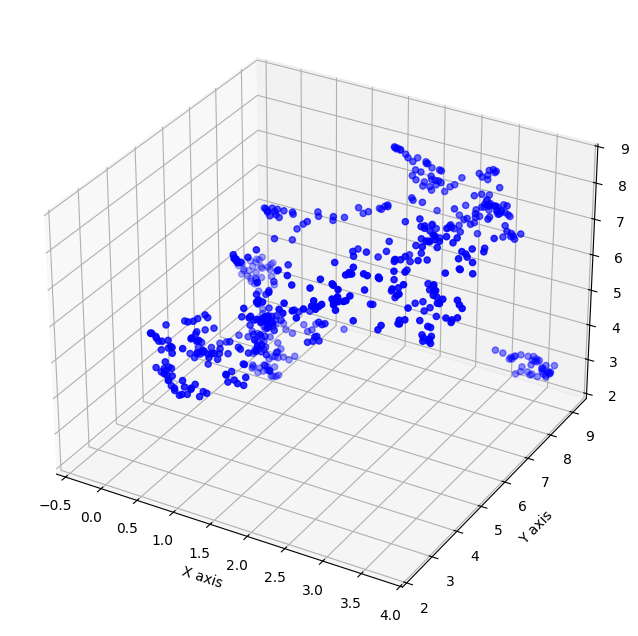

In [64]:
reduced_embeddings = reduce_dimensions(np.array([m['embedding'] for m in messages_with_embeddings]))
plot_3d_embeddings(reduced_embeddings, labels=[m['event_id'] for m in messages_with_embeddings])

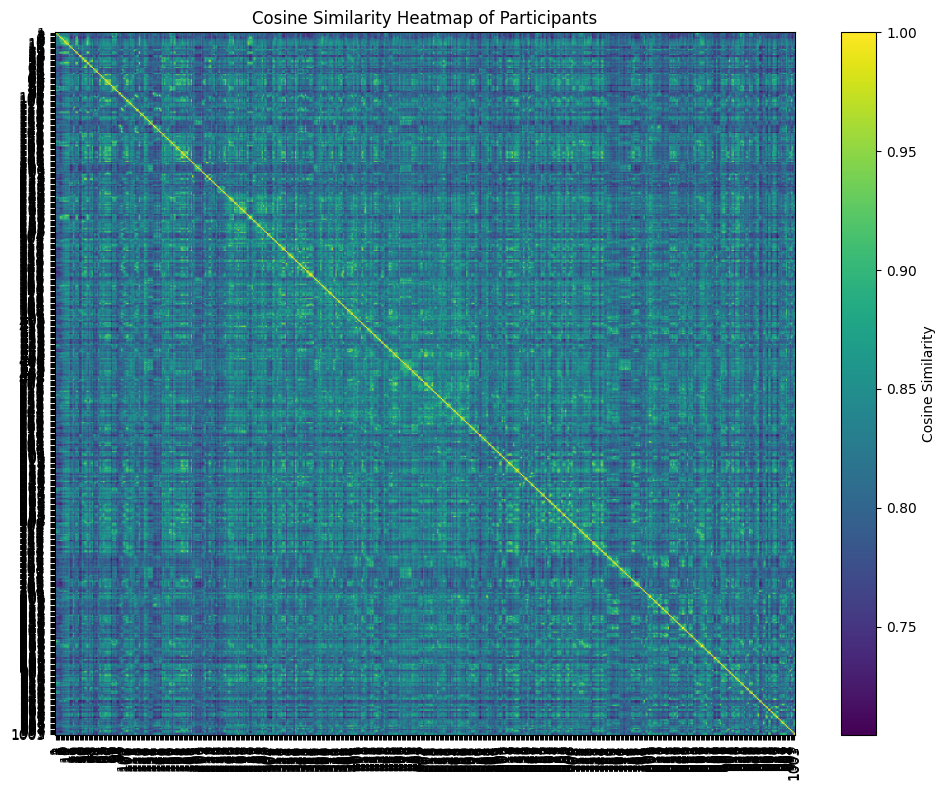

In [65]:
def plot_heatmap(data, title="Cosine Similarity Heatmap"):
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    plt.title(title)
    plt.xticks(ticks=range(len(data.columns)), labels=data.columns, rotation=90)
    plt.yticks(ticks=range(len(data.index)), labels=data.index)
    plt.tight_layout()
    plt.show()

plot_heatmap(similarity_df, title="Cosine Similarity Heatmap of Participants")

In [ ]:
S = np.clip(similarity_matrix, 0, 1)  # Ensure values are between 0 and 1
D = 1 - S  # Convert similarity to distance

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

condensed_distance = squareform(D, checks=False)
Z = linkage(condensed_distance, method='average')


In [ ]:
# Fcluster the distance matrix
clusters = fcluster(Z, t=0.20, criterion='distance') # Threshold for clustering, is 0.80 cosine similarity
# Add cluster labels to the DataFrame
messages_df['fcluster'] = clusters

In [ ]:
messages_df

event_id             datetime  \
0          1  2040-10-01 08:09:00   
1          2  2040-10-01 08:10:00   
2          3  2040-10-01 08:13:00   
3          5  2040-10-01 08:16:00   
4          6  2040-10-01 08:19:00   
..       ...                  ...   
579      994  2040-10-14 12:50:00   
580      997  2040-10-14 12:51:00   
581      999  2040-10-14 13:31:00   
582     1001  2040-10-14 13:34:00   
583     1003  2040-10-14 13:35:00   

                                               content                source  \
0    Hey The Intern, it's The Lookout! Just spotted...           The Lookout   
1    Hey The Lookout, The Intern here! I'd absolute...            The Intern   
2    Sam, it's Kelly! Let's meet at Sunrise Point a...                 Kelly   
3    Mrs. Money, it's The Intern. Just checking in ...            The Intern   
4    Boss, it's Mrs. Money. I've reviewed our opera...            Mrs. Money   
..                                                 ...                   ...   
579  Green Guardians, Oceanus City Council here. Yo...  Oceanus City Council   
580  EcoVigil, Green Guardians HQ here. Your video ...       Green Guardians   
581  Defender to Mako. Be advised that conservation...              Defender   
582  Knowles, Mako here. Proceed to southern dock a...               Knowles   
583  Davis, this is Knowles. Approaching southern d...               Knowles   

              target                                          embedding  \
0         The Intern  [0.02924199216067791, -0.04186283424496651, 0....   
1        The Lookout  [0.03175387531518936, -0.05981292948126793, 0....   
2                Sam  [0.017817039042711258, -0.049655403941869736, ...   
3         Mrs. Money  [0.02555181086063385, -0.03967339172959328, -0...   
4               Boss  [0.03286126255989075, -0.03731901943683624, -0...   
..               ...                                                ...   
579  Green Guardians  [0.003793498734012246, -0.02744883857667446, 0...   
580         EcoVigil  [0.017483510076999664, -0.03820016235113144, 0...   
581             Mako  [0.020824257284402847, -0.013889516703784466, ...   
582            Davis  [0.03646671399474144, -0.04940148442983627, 0....   
583            Davis  [0.03445057198405266, -0.053333383053541183, 0...   

     fcluster  
0           4  
1           4  
2           4  
3           1  
4           4  
..        ...  
579         4  
580         4  
581         4  
582         4  
583         4  

[584 rows x 7 columns]

In [83]:
# Group by cluster and count occurrences
cluster_counts = messages_df.groupby('cluster').size().reset_index(name='count')
# Sort clusters by count
cluster_counts = cluster_counts.sort_values(by='count', ascending=False)
print(cluster_counts)

   cluster  count
3        4    553
1        2     11
4        5      8
0        1      6
2        3      6


In [85]:
source_for_cluster_1 =  messages_df[messages_df['cluster'] == 1]['source'].unique()
source_for_cluster_2 = messages_df[messages_df['cluster'] == 2]['source'].unique()
source_for_cluster_3 = messages_df[messages_df['cluster'] == 3]['source'].unique()
source_for_cluster_4 = messages_df[messages_df['cluster'] == 4]['source'].unique()
source_for_cluster_5 = messages_df[messages_df['cluster'] == 5]['source'].unique()
print(f"Sources for cluster 1: {source_for_cluster_1}")
print(f"Sources for cluster 2: {source_for_cluster_2}")
print(f"Sources for cluster 3: {source_for_cluster_3}")
print(f"Sources for cluster 4: {source_for_cluster_4}")
print(f"Sources for cluster 5: {source_for_cluster_5}")

Sources for cluster 1: ['The Intern' 'Mrs. Money' 'The Middleman' 'The Accountant']
Sources for cluster 2: ['Mako' 'Haacklee Harbor' 'Osprey' 'Reef Guardian' 'Serenity']
Sources for cluster 3: ['Marlin' 'Oceanus City Council' 'Mako']
Sources for cluster 4: ['The Lookout' 'The Intern' 'Kelly' 'Mrs. Money' 'Boss' 'The Middleman'
 'Serenity' 'Himark Harbor' 'Davis' 'Reef Guardian' 'Paackland Harbor'
 'Remora' 'Oceanus City Council' 'Liam Thorne' 'Mako' 'Green Guardians'
 'Samantha Blake' 'Glitters Team' 'Sentinel' 'Horizon' 'EcoVigil'
 'Miranda Jordan' 'Clepper Jensen' 'Rodriguez' 'Small Fry' 'Defender'
 'V. Miesel Shipping' 'Northern Light' 'Sailor Shifts Team' 'Marlin'
 'Haacklee Harbor' 'Nadia Conti' 'Sam' 'Neptune' 'Elise' 'Osprey'
 'Seawatch' 'The Accountant' 'Knowles']
Sources for cluster 5: ['Himark Harbor' 'Horizon' 'The Lookout' 'Sentinel' 'Green Guardians'
 'EcoVigil']


In [134]:
persons

label            name sub_type              id  is_pseudonym
0              Sam             Sam   Person             Sam         False
1            Kelly           Kelly   Person           Kelly          True
2      Nadia Conti     Nadia Conti   Person     Nadia Conti          True
3            Elise           Elise   Person           Elise          True
4      Liam Thorne     Liam Thorne   Person     Liam Thorne         False
5   Samantha Blake  Samantha Blake   Person  Samantha Blake         False
6            Davis           Davis   Person           Davis         False
7        Rodriguez       Rodriguez   Person       Rodriguez          True
8     Sailor Shift    Sailor Shift   Person    Sailor Shift          True
9   Clepper Jensen  Clepper Jensen   Person  Clepper Jensen         False
10  Miranda Jordan  Miranda Jordan   Person  Miranda Jordan         False
11      The Intern      The Intern   Person      The Intern          True
12     The Lookout     The Lookout   Person     The Lookout          True
13  The Accountant  The Accountant   Person  The Accountant          True
14      Mrs. Money      Mrs. Money   Person      Mrs. Money          True
15   The Middleman   The Middleman   Person   The Middleman          True
16            Boss            Boss   Person            Boss          True
17       Small Fry       Small Fry   Person       Small Fry          True

In [143]:
# give me only the persons that are in the clusters1 
persons_in_clusters = persons[persons['id'].isin(messages_df[messages_df['fcluster'] == 5]['source'].unique())]

In [144]:
persons_in_clusters

label         name sub_type           id  is_pseudonym
12  The Lookout  The Lookout   Person  The Lookout          True

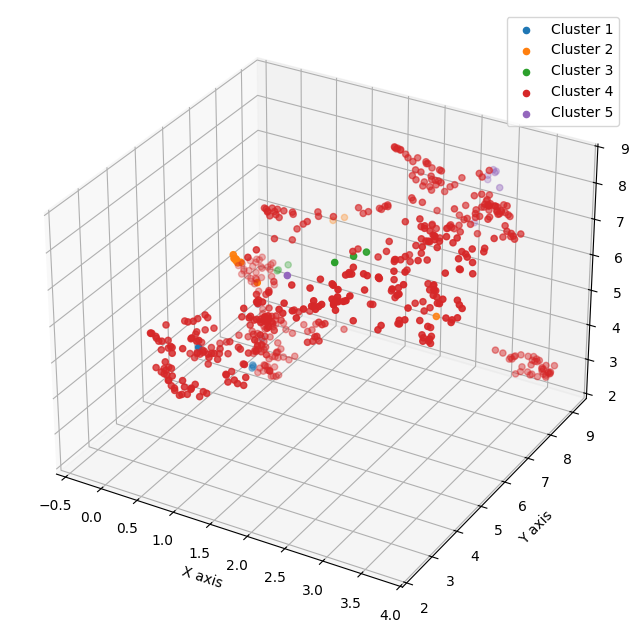

In [113]:
def plot_dendrogram(Z, labels):
    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event ID')
    plt.ylabel('Distance')
    plt.show()

def plot_clusters(embeddings: np.ndarray, clusters: np.ndarray):
    """
    Plot the clustered embeddings in 3D space.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_points = embeddings[clusters == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster}')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.legend()
    plt.show()

# plot_dendrogram(Z, labels=messages_df['event_id'].tolist())
plot_clusters(reduced_embeddings, clusters)